In [50]:
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
import pandas as pd


In [51]:
#read csv file downloaded from kaggle
dataset=read_csv('stock data.csv')
dataset[dataset.Name=='AAPL'].head()

,date,open,high,low,close,volume,Name
1259,08/02/2013,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,11/02/2013,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,12/02/2013,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,13/02/2013,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,14/02/2013,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [52]:
symbols = list(set(dataset.Name))
print('Number of unique stocks in the data set', len(symbols))


Number of unique stocks in the data set 505


In [53]:
#Analyse Apple stock: reformat the data by changing the index date and drop Name Column
temp=pd.DataFrame(dataset[dataset.Name=='AAPL'])
temp.set_index('date', inplace=True)
temp.drop('Name',axis=1, inplace=True)
print('Number of data in dataset: ', len(temp))
temp.head()

Number of data in dataset:  1259


,open,high,low,close,volume
date,,,,,
08/02/2013,67.7142,68.4014,66.8928,67.8542,158168416
11/02/2013,68.0714,69.2771,67.6071,68.5614,129029425
12/02/2013,68.5014,68.9114,66.8205,66.8428,151829363
13/02/2013,66.7442,67.6628,66.1742,66.7156,118721995
14/02/2013,66.3599,67.3771,66.2885,66.6556,88809154


In [54]:
#check if any NA
temp.isna().any()

open      False
high      False
low       False
close     False
volume    False
dtype: bool

In [55]:
#see if any outliers in the dataset and if makes common sense
temp.describe()

,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,109.055429,109.951118,108.141589,109.066698,5.404790e+07
std,30.549220,30.686186,30.376224,30.556812,3.346835e+07
min,55.424200,57.085700,55.014200,55.789900,1.147592e+07
25%,84.647800,85.334950,84.250650,84.830650,2.969438e+07
50%,108.970000,110.030000,108.050000,109.010000,4.566893e+07
75%,127.335000,128.100000,126.290000,127.120000,6.870872e+07
max,179.370000,180.100000,178.250000,179.260000,2.668336e+08


In [56]:
#Shuffle the columns such that close price is the last column
columns=['open', 'high', 'low', 'volume','close']
temp=temp[columns]
temp.head()

,open,high,low,volume,close
date,,,,,
08/02/2013,67.7142,68.4014,66.8928,158168416,67.8542
11/02/2013,68.0714,69.2771,67.6071,129029425,68.5614
12/02/2013,68.5014,68.9114,66.8205,151829363,66.8428
13/02/2013,66.7442,67.6628,66.1742,118721995,66.7156
14/02/2013,66.3599,67.3771,66.2885,88809154,66.6556


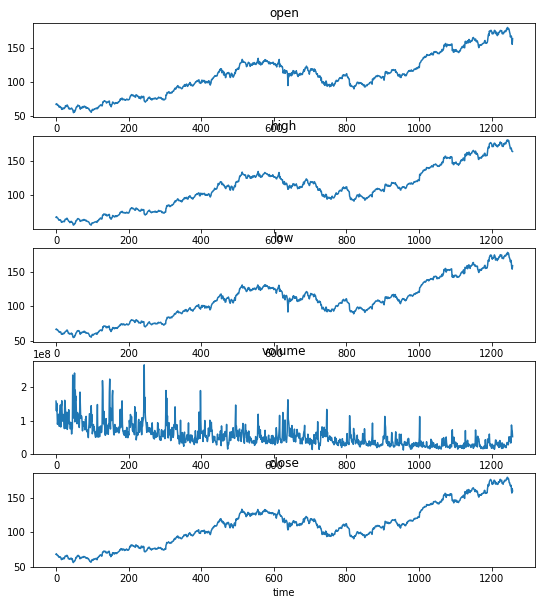

In [57]:
#plot the dataset
from matplotlib import pyplot
values=temp.values
groups=[0,1,2,3,4]
i=1
pyplot.figure(figsize=(9,10
                      ))
for group in groups:
    pyplot.subplot(len(groups),1,i)
    pyplot.plot(values[:, group])
    
    pyplot.title(temp.columns[group])
    i+=1
pyplot.xlabel("time")
pyplot.show()

In [58]:
#convert the raw data to multivariant dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
   
    n_vars=1 if type(data) is list else data.shape[1]
  
    df=DataFrame(data)
    cols, names=list(), list()
    for i in range(n_in, 0,-1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)'%(j+1,i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names+=[('var%d(t)'%(j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d)'%(j+1, i)) for j in range(n_vars)]
    agg=concat(cols, axis=1)
    agg.columns=names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

                    

In [59]:
temp.head(8)

,open,high,low,volume,close
date,,,,,
08/02/2013,67.7142,68.4014,66.8928,158168416,67.8542
11/02/2013,68.0714,69.2771,67.6071,129029425,68.5614
12/02/2013,68.5014,68.9114,66.8205,151829363,66.8428
13/02/2013,66.7442,67.6628,66.1742,118721995,66.7156
14/02/2013,66.3599,67.3771,66.2885,88809154,66.6556
15/02/2013,66.9785,67.1656,65.7028,97924631,65.7371
19/02/2013,65.8714,66.1042,64.8356,108854046,65.7128
20/02/2013,65.3842,65.3842,64.1142,118891367,64.1214


In [60]:
#n_days is number of days one would like to go back in time from time (t). ie predicting closing price at time t 
#based on past n_days of open/high/low/volumn/closing prices. 
#We have used 7 as an arbitrary selected numbere here.
n_days=7

#rescale the dataset
scaler=MinMaxScaler(feature_range=(0,1))
scaled=scaler.fit_transform(values)

#transform the raw data into multivariable set. there should be n_days*5 + 5 columns = 40. Of which 35 will be used
#to predict closing price on day t, and 1 would be the target prediction.
reframed=series_to_supervised(scaled,n_days,1)

reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
7,0.099156,0.091987,0.096389,0.574459,0.097710,0.102038,0.099106,0.102185,0.460348,0.103438,...,0.084288,0.073313,0.079696,0.381340,0.080367,0.080358,0.067460,0.073842,0.420647,0.067478
8,0.102038,0.099106,0.102185,0.460348,0.103438,0.105507,0.096133,0.095803,0.549635,0.089519,...,0.080358,0.067460,0.073842,0.420647,0.067478,0.066884,0.057566,0.066910,0.392081,0.064250
9,0.105507,0.096133,0.095803,0.549635,0.089519,0.091330,0.085983,0.090558,0.419984,0.088489,...,0.066884,0.057566,0.066910,0.392081,0.064250,0.070630,0.060387,0.071292,0.278464,0.069746
10,0.091330,0.085983,0.090558,0.419984,0.088489,0.088230,0.083660,0.091486,0.302843,0.088003,...,0.070630,0.060387,0.071292,0.278464,0.069746,0.075932,0.064475,0.066620,0.318861,0.060478
11,0.088230,0.083660,0.091486,0.302843,0.088003,0.093221,0.081941,0.086733,0.338540,0.080564,...,0.075932,0.064475,0.066620,0.318861,0.060478,0.064372,0.060317,0.060929,0.444947,0.067616


In [61]:
print('reframed shape: ', reframed.shape)


reframed shape:  (1252, 40)


In [62]:

values=reframed.values
#n_features are features for prediction, and they are open price/high/low/volumn/closing price for the previous n_days
n_features=5

#n_obs is number of observation needed to predict any given day's closing price
n_obs=n_days*n_features

#seet training set to be 90% of the total set, and testing 10%
n_train = int(len(reframed)*0.9)
n_test=len(reframed)-n_train
print('number of training set: ', n_train)
print('number of test set: ', n_test)

train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

print("train_X.shape, len(train_X), train_y.shape: ", train_X.shape, len(train_X), train_y.shape)
print("test_X.shape, len(test_X), test_y.shape: ", test_X.shape, len(test_X), test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))


number of training set:  1126
number of test set:  126
train_X.shape, len(train_X), train_y.shape:  (1126, 35) 1126 (1126,)
test_X.shape, len(test_X), test_y.shape:  (126, 35) 126 (126,)


In [63]:
#bring target outcome back to its orignal scale
ymax=temp.close.max()
ymin=temp.close.min()
test_y=test_y*(ymax-ymin)+ymin

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 20)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 21        
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
 - 8s - loss: 0.3915
Epoch 2/20
 - 0s - loss: 0.0930
Epoch 3/20
 - 0s - loss: 0.1366
Epoch 4/20
 - 0s - loss: 0.0587
Epoch 5/20
 - 0s - loss: 0.0441
Epoch 6/20
 - 0s - loss: 0.0234
Epoch 7/20
 - 0s - loss: 0.0192
Epoch 8/20
 - 0s - loss: 0.0208
Epoch 9/20
 - 0s - loss: 0.0205
Epoch 10/20
 - 0s - loss: 0.0187
Epoch 11/20
 - 0s - loss: 0.0183
Epoch 12/20
 - 0s - loss: 0.0182
Epoch 13/20
 - 0s - loss: 0.0180
Epoch 14/20
 - 0s - loss: 0.0179
Epoch 15/20
 - 0s - loss: 0.0179
Epoch 16/20
 - 0s - loss: 0.0178
Epoch 17/20
 - 0s

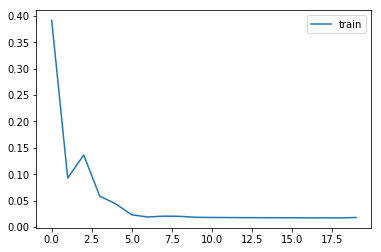

In [64]:
#Model 1: a simple model with one LSTM layer and one dense layer
model=Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
history=model.fit(train_X, train_y, epochs=20, batch_size=72, verbose=2, shuffle=False)

yhat=model.predict(test_X)
yhat=yhat*(ymax-ymin)+ymin 

print('model 1 MSE: ',mean_squared_error(test_y, yhat))

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()


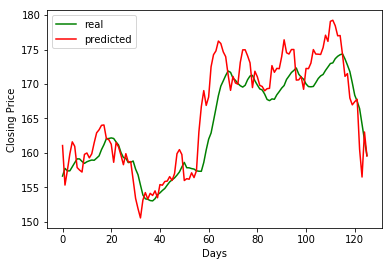

In [65]:
pyplot.plot(yhat, color='g',  label='real')
pyplot.plot(test_y, color='r', label='predicted')
pyplot.ylabel('Closing Price')
pyplot.xlabel('Days')
pyplot.legend()
pyplot.show()


Our Simple model had produced a very low MSE and plotting predicted vs real, it is bloody good!

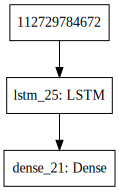

In [66]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 50)                11200     
_________________________________________________________________
dropout_32 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1632      
_________________________________________________________________
dropout_33 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 4s - loss: 0.1981
Epoch 2/30
 - 0s - loss: 0.1784
Epoch 3/30
 - 0s - loss: 0.1350
Epoch 4/30
 - 0s - loss: 0.1160
Epoch 5/30

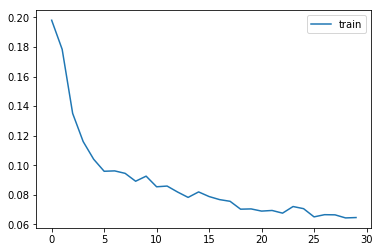

In [67]:
#Model 2: try a more nodes and multiple dense layer with activation relu in dense layer 1
model2=Sequential()
model2.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='linear'))
model2.compile(loss='mae', optimizer='adam')
model2.summary()
history2=model2.fit(train_X, train_y, epochs=30, batch_size=72, verbose=2, shuffle=False)

yhat2=model2.predict(test_X)
yhat2=yhat2*(ymax-ymin)+ymin

print('model 2 MSE: ',mean_squared_error(test_y, yhat2))

pyplot.plot(history2.history['loss'], label='train')
pyplot.legend()
pyplot.show()

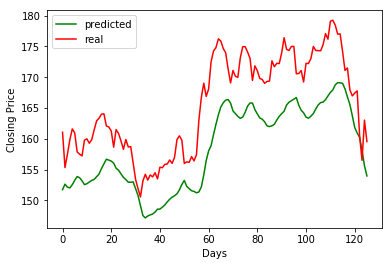

In [68]:
pyplot.plot(yhat2, color='g',  label='predicted')
pyplot.plot(test_y, color='r', label='real')
pyplot.ylabel('Closing Price')
pyplot.xlabel('Days')
pyplot.legend()
pyplot.show()


The model prediction result is consistently lower than actual values. There is also a significant increase in MSE. The result is pretty aweful. This could be the activation of 'relu' - not a good activate for time series problem.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 50)                11200     
_________________________________________________________________
dropout_42 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                1632      
_________________________________________________________________
dropout_43 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 33        
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 5s - loss: 0.2011
Epoch 2/30
 - 0s - loss: 0.1765
Epoch 3/30
 - 0s - loss: 0.1284
Epoch 4/30
 - 0s - loss: 0.1051
Epoch 5/30

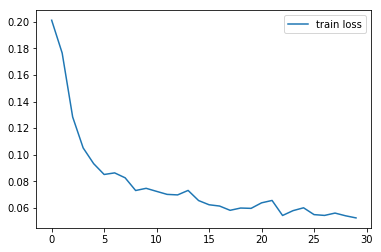

In [76]:
#Model 3: try with activation linear, 2 LSTM layers, and a random guess of 30 nodes for LSTM
model3=Sequential()
model3.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model3.add(Dropout(0.5))
model3.add(Dense(32, activation='linear'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='linear'))
model3.compile(loss='mae', optimizer='adam')
model3.summary()
history3=model3.fit(train_X, train_y, epochs=30, batch_size=72, verbose=2, shuffle=False)

yhat3=model3.predict(test_X)
yhat3=yhat3*(ymax-ymin)+ymin
print('model 3 MSE: ',mean_squared_error(test_y, yhat3))

pyplot.plot(history3.history['loss'], label='train loss')
pyplot.legend()
pyplot.show()

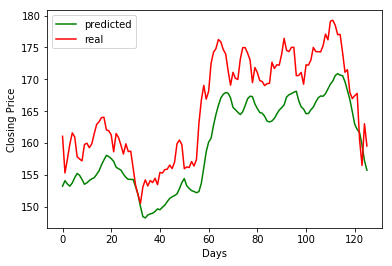

In [77]:
pyplot.plot(yhat3, color='g',  label='predicted')
pyplot.plot(test_y, color='r', label='real')
pyplot.ylabel('Closing Price')
pyplot.xlabel('Days')
pyplot.legend()
pyplot.show()


Model 3 is better when using linear activation. However, it seems complexity doesn't improve performance compare with the first simple model.

Nodes:  30
Epoch 1/30
 - 10s - loss: 0.1496
Epoch 2/30
 - 0s - loss: 0.1804
Epoch 3/30
 - 0s - loss: 0.1180
Epoch 4/30
 - 0s - loss: 0.1011
Epoch 5/30
 - 0s - loss: 0.0782
Epoch 6/30
 - 0s - loss: 0.0752
Epoch 7/30
 - 0s - loss: 0.0761
Epoch 8/30
 - 0s - loss: 0.0802
Epoch 9/30
 - 0s - loss: 0.0726
Epoch 10/30
 - 0s - loss: 0.0708
Epoch 11/30
 - 0s - loss: 0.0667
Epoch 12/30
 - 0s - loss: 0.0716
Epoch 13/30
 - 0s - loss: 0.0763
Epoch 14/30
 - 0s - loss: 0.0879
Epoch 15/30
 - 0s - loss: 0.0729
Epoch 16/30
 - 0s - loss: 0.0758
Epoch 17/30
 - 0s - loss: 0.0761
Epoch 18/30
 - 0s - loss: 0.0612
Epoch 19/30
 - 0s - loss: 0.0589
Epoch 20/30
 - 0s - loss: 0.0614
Epoch 21/30
 - 0s - loss: 0.0605
Epoch 22/30
 - 0s - loss: 0.0600
Epoch 23/30
 - 0s - loss: 0.0617
Epoch 24/30
 - 0s - loss: 0.0775
Epoch 25/30
 - 0s - loss: 0.0631
Epoch 26/30
 - 0s - loss: 0.0718
Epoch 27/30
 - 0s - loss: 0.0615
Epoch 28/30
 - 0s - loss: 0.0737
Epoch 29/30
 - 0s - loss: 0.0612
Epoch 30/30
 - 0s - loss: 0.0655
model 4

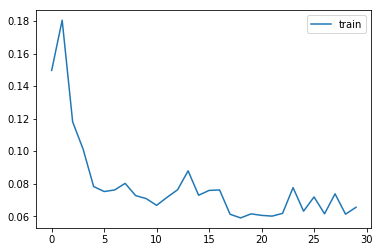

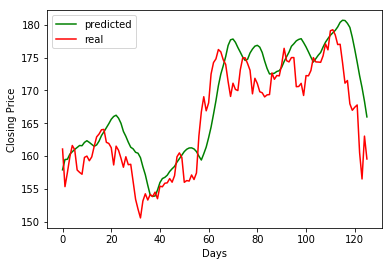

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 7, 30)             4320      
_________________________________________________________________
dropout_44 (Dropout)         (None, 7, 30)             0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 7, 30)             7320      
_________________________________________________________________
dropout_45 (Dropout)         (None, 7, 30)             0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_46 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 20)                620       
__________

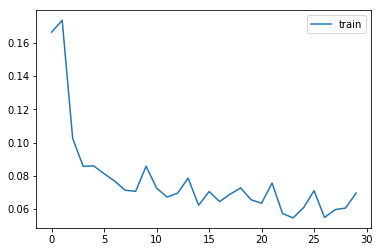

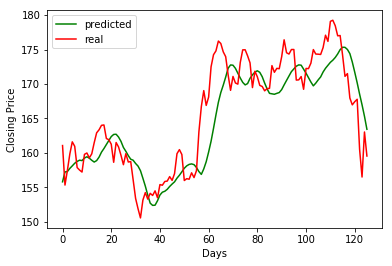

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 7, 40)             7360      
_________________________________________________________________
dropout_48 (Dropout)         (None, 7, 40)             0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 7, 40)             12960     
_________________________________________________________________
dropout_49 (Dropout)         (None, 7, 40)             0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dropout_50 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 20)                820       
__________

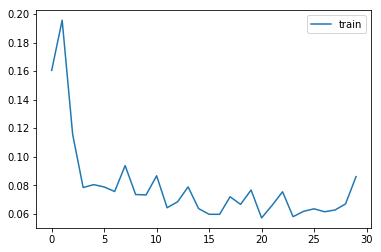

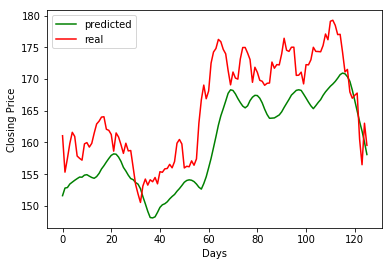

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 7, 50)             11200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 7, 50)             0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 7, 50)             20200     
_________________________________________________________________
dropout_53 (Dropout)         (None, 7, 50)             0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_54 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 20)                1020      
__________

In [78]:
#Model 4: try different nodes (30, 40, and 50) and 3 LSTM layers with linear dense layers
for i in range (30, 60, 10):
    print ('Nodes: ', i)
    model4=Sequential()
    model4.add(LSTM(i, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
    model4.add(Dropout(0.3))
    model4.add(LSTM(i, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
    model4.add(Dropout(0.3))
    model4.add(LSTM(i,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False))
    model4.add(Dropout(0.3))
    model4.add(Dense(20, activation='linear'))
    model4.add(Dropout(0.3))
    model4.add(Dense(1, activation='linear'))
    model4.compile(loss='mae', optimizer='adam')
    
    history4=model4.fit(train_X, train_y, epochs=30, batch_size=72,  verbose=2, shuffle=False)

    yhat4=model4.predict(test_X)
    yhat4=yhat4*(ymax-ymin)+ymin
    print('model 4 MSE: ',mean_squared_error(test_y, yhat4))

    pyplot.plot(history4.history['loss'], label='train')
    pyplot.legend()
    pyplot.show()
    
    pyplot.plot(yhat4, color='g',  label='predicted')
    pyplot.plot(test_y, color='r', label='real')
    pyplot.ylabel('Closing Price')
    pyplot.xlabel('Days')
    pyplot.legend()
    pyplot.show()
    model4.summary()
    

The model with 50 nodes seems to performed the best in Model 4. The MSE is a fraction of previous model. However, the simple model 1 is still the best of the bunch. In conclusion, complexity isn't necessary the best in this case. Model 1 with one LSTM layer and one Dense layer is the best solution. 